In [ ]:
!install_tesseract.sh

## download

In [ ]:
%%bash
#download font

rm -r fonts 
mkdir -p fonts
cd fonts/

wget -nc   https://github.com/google/fonts/raw/main/ofl/kleeone/KleeOne-Regular.ttf
wget -nc  https://github.com/google/fonts/raw/main/ofl/notoserifjp/NotoSerifJP%5Bwght%5D.ttf
wget -nc  https://github.com/google/fonts/raw/main/ofl/mplus1p/MPLUS1p-Regular.ttf
wget -nc  https://github.com/google/fonts/raw/main/ofl/zenantique/ZenAntique-Regular.ttf
wget -nc  https://github.com/google/fonts/raw/main/ofl/zenkurenaido/ZenKurenaido-Regular.ttf
wget -nc  https://github.com/google/fonts/raw/main/ofl/zenkakugothicantique/ZenKakuGothicAntique-Regular.ttf
wget -nc  https://github.com/google/fonts/raw/main/ofl/zenoldmincho/ZenOldMincho-Regular.ttf
wget -nc  https://github.com/google/fonts/raw/main/ofl/zenmarugothic/ZenMaruGothic-Regular.ttf

wget -nc https://github.com/google/fonts/raw/main/ofl/yujisyuku/YujiSyuku-Regular.ttf
wget -nc  https://github.com/google/fonts/raw/main/ofl/yujiboku/YujiBoku-Regular.ttf
wget -nc  https://github.com/google/fonts/raw/main/ofl/rampartone/RampartOne-Regular.ttf
wget -nc  https://github.com/google/fonts/raw/main/ofl/dotgothic16/DotGothic16-Regular.ttf
wget -nc  https://github.com/google/fonts/raw/main/ofl/hachimarupop/HachiMaruPop-Regular.ttf
wget -nc   https://github.com/google/fonts/raw/main/ofl/newtegomin/NewTegomin-Regular.ttf
wget -nc  https://github.com/google/fonts/raw/main/ofl/kaiseiopti/KaiseiOpti-Regular.ttf
wget -nc  https://github.com/google/fonts/raw/main/apache/kosugimaru/KosugiMaru-Regular.ttf




# https://github.com/google/fonts/raw/main/ofl/trainone/TrainOne-Regular.ttf
#   https://github.com/google/fonts/raw/main/ofl/reggaeone/ReggaeOne-Regular.ttf
#  https://github.com/google/fonts/raw/main/ofl/yomogi/Yomogi-Regular.ttf
# noto sans jp
# KaiseiDecol-Regular.ttf
# KiwiMaru-Regular.ttf
# fonts/RocknRollOne-Regular.ttf
# fonts/MochiyPopOne-Regular.ttf

In [ ]:
%%bash
#download model


cd model/
wget  -nc https://github.com/NbtKmy/jpn_vert_improvement/raw/main/traineddata/jpn_vert_v4.traineddata
wget  -nc https://github.com/zodiac3539/jpn_vert/raw/master/jpn_ver5.traineddata
wget  -nc https://github.com/tesseract-ocr/tessdata_best/raw/main/jpn_vert.traineddata



# # Extract the trainned model
combine_tessdata -u jpn_ver5.traineddata jpn_ver5

In [ ]:
%%bash
#download test data


cd test/
#wget   -nc https://raw.githubusercontent.com/ttop32/JMTrans/master/doc/result1.png
cd ..

In [ ]:
import os
cwd = os.getcwd()
os.environ["TESSDATA_PREFIX"] = cwd
import pytesseract
from PIL import Image               # to load images
from IPython.display import display # to display images
import cv2
import matplotlib.pyplot as plt
from glob import glob 
from fontTools import ttLib
import os
from PIL import Image, ImageSequence
import re
import shutil
import random
from tqdm import tqdm
import numpy as np
from itertools import product
from pytesseract import Output
import json


print(pytesseract.get_tesseract_version())




    
dataTxtFilteredPath="data_txt_filtered/"
dataTxtSplitPath="data_txt_split/"
dataLstmfTempPath="data_lstmf_temp/"




LANG="jpn"
MAX_PAGES=0  #0 for whole text
NUM_ITERATIONS=5000000

LANG_DATA_DIR="tesseract/langdata_lstm"
TESSDATA_DIR="tesseract/tessdata"
MODEL_DIR="model"
OUTPUT_DIR="output"
TRAIN_DIR="data_lstmf"

# TRAINING_TEXT="untitled.txt"
# TRAINING_TEXT=${LANG_DATA_DIR}/${LANG}/${LANG}.training_text 

OUTPUT_NAME="jpn_vert_new"
START_MODEL="jpn_ver5"



def resetFolder(path):
    if  os.path.exists(path):
        shutil.rmtree(path)
    os.makedirs(path, exist_ok=True)



## preprocess text data 




In [ ]:
#get model unicharset list
!combine_tessdata -u $MODEL_DIR/$START_MODEL".traineddata" $MODEL_DIR/$START_MODEL


uniPath= os.path.join(MODEL_DIR,START_MODEL+'.lstm-unicharset')
with open(uniPath, "r", encoding="UTF-8") as f:
    unicharsetLines = f.readlines()
    unicharsetList=[line[0] for line in unicharsetLines][3:]
    

In [ ]:
#filter training text
#only contain string that exist in model unicharset

txtPathList=glob("data_txt/*.txt")
resetFolder(dataTxtFilteredPath)



for txtPath in tqdm(txtPathList):
    fileName=os.path.basename(txtPath) 
    savePath=os.path.join(dataTxtFilteredPath,fileName)

    with open(txtPath, "r", encoding="UTF-8") as f:
        txtLines = f.readlines()

    #filter txt
    newLines=[]
    for i,line in enumerate(txtLines):
        line=[char for char in line if char in unicharsetList]  #only in unichar
        line=''.join(line)
        line = re.sub("[「」《》『』]", "", line)               #remove special char
        line = line.strip()                                    #remove space
        if line:
            newLines+=[line]

    with open(savePath, 'w', encoding="UTF-8") as f:
        f.writelines(s + '\n' for s in newLines)
        

        

In [ ]:
#split text into small txt file
lineSplitMax=200
resetFolder(dataTxtSplitPath)


for txtPath in tqdm(glob(os.path.join(dataTxtFilteredPath,"*.txt"))):
    with open(txtPath, "r", encoding="UTF-8") as f:
        txtLines = f.readlines()        

        
    for i in range(0,len(txtLines),lineSplitMax):
        fileName=os.path.basename(txtPath) 
        savePath=os.path.join(dataTxtSplitPath,str(i)+"_"+fileName)
        
        with open(savePath, 'w', encoding="UTF-8") as f:
            f.writelines(txtLines[i:i+lineSplitMax])       
        

## convert text to image 




In [ ]:
#list font name

fontNameList=[]
ttfList=glob("fonts/*.ttf")
for ttf in ttfList:
    try:
        font = ttLib.TTFont(ttf)
        fontFamilyName = font['name'].getDebugName(1)
        fullName= font['name'].getDebugName(4)
        
        fontNameList+=[fontFamilyName]
    except:
        print(ttf)
fontNameList.sort()
oneLineFont='" "'.join(fontNameList)
oneLineFont='"'+oneLineFont+'"'
print(oneLineFont)


In [ ]:
#text to image
# "Klee One" "M PLUS 1p" "Noto Serif JP" "Zen Antique" "Zen Kaku Gothic Antique" "Zen Kurenaido" "Zen Maru Gothic" "Zen Old Mincho"
# "DotGothic16" "Hachi Maru Pop" "Kaisei Opti" "Klee One" "Kosugi Maru" "M PLUS 1p" "New Tegomin" "Noto Serif JP" "Rampart One" "Yuji Boku" "Yuji Syuku" "Zen Antique" "Zen Kaku Gothic Antique" "Zen Kurenaido" "Zen Maru Gothic" "Zen Old Mincho"
trainingTextList=glob(os.path.join(dataTxtSplitPath,"*.txt"))
random.shuffle(trainingTextList)

resetFolder(dataLstmfTempPath)
resetFolder(TRAIN_DIR)



#create lstmf file for each spllited text
for i, TRAINING_TEXT in enumerate(trainingTextList):
    resetFolder(dataLstmfTempPath)
    
    !python tesstrain.py \
        --lang $LANG \
        --fonts_dir fonts \
        --fontlist "DotGothic16" "Hachi Maru Pop" "Kaisei Opti" "Klee One" "Kosugi Maru" "M PLUS 1p" "New Tegomin" "Noto Serif JP" "Rampart One" "Yuji Boku" "Yuji Syuku" "Zen Antique" "Zen Kaku Gothic Antique" "Zen Kurenaido" "Zen Maru Gothic" "Zen Old Mincho" \
        --langdata_dir $LANG_DATA_DIR \
        --tessdata_dir $TESSDATA_DIR \
        --output_dir $dataLstmfTempPath \
        --maxpages $MAX_PAGES \
        --distort_image \
        --linedata_only \
        --exposures 0 \
        --training_text $TRAINING_TEXT \
        --noextract_font_properties \
        --save_box_tiff \
        --ptsize 24 \
        --writing_mode_vert \
    
    
    #move lstmf  
    for lstmfPath in glob(os.path.join(dataLstmfTempPath,"*.lstmf")):
        fileName=os.path.basename(lstmfPath) 
        savePath=os.path.join(TRAIN_DIR,str(i)+"_"+fileName)
        shutil.move(lstmfPath, savePath)
        
    if i==100:
        break
            

In [ ]:
#create training_files.txt
lstmfList=glob(os.path.join(TRAIN_DIR,"*.lstmf"))
savePath=os.path.join(TRAIN_DIR,LANG+".training_files.txt")
with open(savePath, 'w', encoding="UTF-8") as f:
    f.writelines(s + '\n' for s in lstmfList)

    

In [ ]:
#show images

tifPath=os.path.join(dataLstmfTempPath,'*.tif')


#iterate all tif file, get all pages and show
for path in glob(tifPath):
    print(path)
    pil_im = Image.open(path)

    for i, page in enumerate(ImageSequence.Iterator(pil_im)):
        if i>0: break
        display(page)


## training


In [ ]:
!bash train.sh


In [31]:

# # convert checkpoint to .traineddata
!lstmtraining --stop_training \
    --continue_from $OUTPUT_DIR/$OUTPUT_NAME"_checkpoint" \
	--traineddata $MODEL_DIR/$START_MODEL".traineddata" \
    --model_output $MODEL_DIR/$OUTPUT_NAME".traineddata"


Loaded file output/jpn_vert_new23_checkpoint, unpacking...


## test

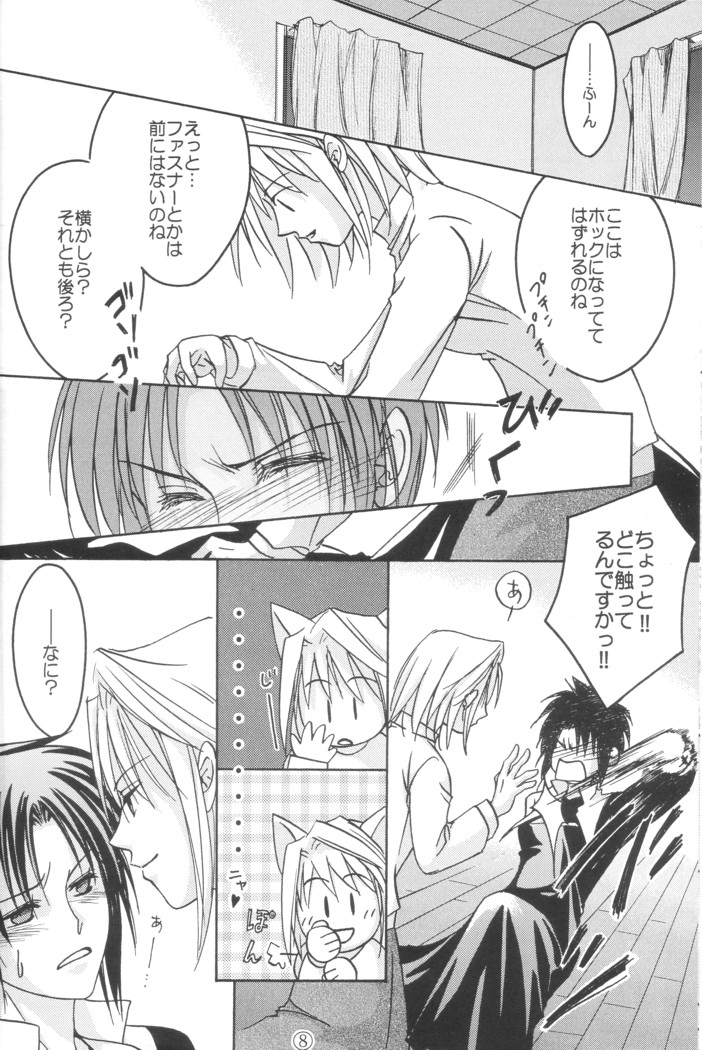

model/jpn_ver5
      悶                       ちょっと‼
疾                  旋也⁈
到尼                       かっ‼
o       ボッヅクになってて
加量倫了     系有旋外
92

ワ-スナーたかは
ヮスナーとかは
女路小

かしら?
評い千⁈

model/jpn_vert_new
えっと…
ワァスサナーにかは
前にはないのね

横かしら?
それ上き後ろ?

ちょっと!
ピこ強って
るんですかっ


model/jpn_vert_v4
                       ちょつとリ
捉                  放っ
にて                       かつり
       ボックになってて
/、湾下     はずれるのね
の4v0全

ファスナーとかは
アスナーとかは
門にはないのね

かしら?
それとも後ろア

model/jpn_vert
                       ちょっとリ=
如                  旋軸っ
にては                       かっリ
       ホックになってて
/     はずれるのね
0人

ファスナーとかは
ァスナーとかは
記にはないのね

かしら?
それとも後ろ?



In [35]:
#test model

testImgPath='test/07.jpg'

img = Image.open(testImgPath)
display(img)
img = cv2.imread(testImgPath)
img= cv2.cvtColor(img, cv2.COLOR_BGR2RGB)



oem=1
psm=1
traineddataList=glob('model/*.traineddata')


for traineddata in traineddataList:
    traineddata=traineddata.replace('.traineddata', '')
    
    ocr_result = pytesseract.image_to_string(image=img, lang=traineddata, config='--oem ' + str(oem) + ' --psm ' + str(psm))
    print(traineddata)
    print(ocr_result)


## change model config

In [32]:

#extract current config
!combine_tessdata -u $MODEL_DIR/$OUTPUT_NAME".traineddata" $MODEL_DIR/$OUTPUT_NAME

#list param list
# !tesseract --print-parameters

Extracting tessdata components from model/jpn_vert_new25.traineddata
Wrote model/jpn_vert_new25.config
Wrote model/jpn_vert_new25.lstm
Wrote model/jpn_vert_new25.lstm-punc-dawg
Wrote model/jpn_vert_new25.lstm-word-dawg
Wrote model/jpn_vert_new25.lstm-number-dawg
Wrote model/jpn_vert_new25.lstm-unicharset
Wrote model/jpn_vert_new25.lstm-recoder
Wrote model/jpn_vert_new25.version
Version:4.0.0-beta.3
0:config:size=2653, offset=192
17:lstm:size=13014691, offset=2845
18:lstm-punc-dawg:size=2714, offset=13017536
19:lstm-word-dawg:size=1007922, offset=13020250
20:lstm-number-dawg:size=978, offset=14028172
21:lstm-unicharset:size=281070, offset=14029150
22:lstm-recoder:size=66596, offset=14310220
23:version:size=12, offset=14376816


In [33]:
#update config
!combine_tessdata -o $MODEL_DIR/$OUTPUT_NAME".traineddata" $MODEL_DIR/$OUTPUT_NAME".config"


Version:4.0.0-beta.3
0:config:size=2915, offset=192
17:lstm:size=13014691, offset=3107
18:lstm-punc-dawg:size=2714, offset=13017798
19:lstm-word-dawg:size=1007922, offset=13020512
20:lstm-number-dawg:size=978, offset=14028434
21:lstm-unicharset:size=281070, offset=14029412
22:lstm-recoder:size=66596, offset=14310482
23:version:size=12, offset=14377078


In [ ]:


# textord_max_noise_size  3
# textord_minxh  10.0
# textord_min_linesize 1.7
# textord_overlap_x 10
# textord_occupancy_threshold 10
# textord_min_xheight 10



# textord_noise_syfract 0.7
# textord_noise_sxfract 0.7
# textord_noise_hfract 0.015
# textord_noise_area_ratio 1.4



In [ ]:
# # update model config then show result

# !combine_tessdata -o $MODEL_DIR/$OUTPUT_NAME".traineddata" $MODEL_DIR/$OUTPUT_NAME".config"

# oem=1
# psm=1
# testImgPath='test/07.jpg'
# traineddata=os.path.join(MODEL_DIR,OUTPUT_NAME)

# img = cv2.imread(testImgPath)
# d = pytesseract.image_to_data(image=img, lang=traineddata, config='--oem ' + str(oem) + ' --psm ' + str(psm),  output_type='dict')
# ocr_result = pytesseract.image_to_string(image=img, lang=traineddata, config='--oem ' + str(oem) + ' --psm ' + str(psm))
# print(ocr_result)

# n_boxes = len(d['level'])
# for i in range(n_boxes):
#     if d['width'][i]*d['height'][i]<100 :
#         continue
#     (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
#     cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
    
# plt.figure(figsize = (10,10))
# plt.imshow(img, )
# plt.show()


In [ ]:

# # create config for looping all possible option

# psm=1
# oem=1
# testImgPath='test/07.jpg'
# img = Image.open(testImgPath)
# traineddata=os.path.join(MODEL_DIR,OUTPUT_NAME)
# configPath=os.path.join(MODEL_DIR,OUTPUT_NAME+".config")

# with open(configPath, "r", encoding="UTF-8") as f:
#     configLines = f.readlines()

# configDict={
#     "textord_max_noise_size":list(range(1,15,1)),
#     "textord_minxh":list(np.arange(0.1,10,0.2)),
#     "textord_min_linesize":list(np.arange(0.6,2.0,0.2)),
#     "textord_overlap_x":list(np.arange(1,10,2)),
#     "textord_occupancy_threshold":list(np.arange(1,10,2)),
#     "textord_min_xheight":list(np.arange(1,10,2)),
# }

# bestOption=dict()

# #possible option list
# configNameList=[]
# configOptionList=[]
# for key, value in configDict.items():
#     configNameList+=[key]
#     configOptionList+=[value]

# configRemainDefault=[]

# for i,line in enumerate(configLines):
#     if(not any([name for name in configNameList if name in line])):
#         configRemainDefault+=[line]

        
# for i in configRemainDefault:
#     print(i)




In [ ]:
# resultTxt="test.txt"

# #iterate all possible list
# for optionCombo in tqdm(product(*configOptionList)):
#     currentOption=configRemainDefault[:]

    
#     for name,option in zip(configNameList,optionCombo):
#         currentOption+=[name+" "+str(option)+"\n"]
    
            
#     with open(configPath, 'w', encoding="UTF-8") as f:
#         f.writelines(currentOption)

#     !combine_tessdata -o $MODEL_DIR/$OUTPUT_NAME".traineddata" $MODEL_DIR/$OUTPUT_NAME".config"

#     ocr_result = pytesseract.image_to_string(image=img, lang=traineddata, config='--oem ' + str(oem) + ' --psm ' + str(psm))
#     print(len(ocr_result))
#     bestOption[str(len(ocr_result))]=[optionCombo,ocr_result]
    

#     with open(resultTxt, 'w', encoding="UTF-8") as f:
#         f.write(json.dumps(bestOption, ensure_ascii=False,indent=4, ))
    
    
# bestOption
        

2